In [40]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import statsmodels.api as sm
from statstests.process import stepwise
from sklearn.metrics import roc_curve, auc

In [41]:
# Import e tratamento dos dados 

df_fidelidade = pd.read_csv('data/dados_fidelidade.csv',delimiter=',')

df_fidelidade['id'] = df_fidelidade['id'].astype('str')
df_fidelidade['atendimento'] = df_fidelidade['atendimento'].astype('object')
df_fidelidade['sortimento'] = df_fidelidade['sortimento'].astype('object')
df_fidelidade['acessibilidade'] = df_fidelidade['acessibilidade'].astype('object')
df_fidelidade['preço'] = df_fidelidade['preço'].astype('object')

df_fidelidade.loc[df_fidelidade['fidelidade']=='sim', 'fidelidade'] = 1
df_fidelidade.loc[df_fidelidade['fidelidade']=='nao', 'fidelidade'] = 0

df_fidelidade['fidelidade'] = df_fidelidade['fidelidade'].astype('int64')

# Dados sem dummies
df_fidelidade.head()

,id,fidelidade,sexo,idade,atendimento,sortimento,acessibilidade,preço
0,1,0,feminino,34,2,2,1,1
1,2,0,feminino,34,2,2,1,1
2,3,0,masculino,34,3,2,4,2
3,4,0,feminino,34,4,3,3,3
4,5,0,feminino,34,4,3,1,4


In [42]:
df_fidelidade_dummies = pd.get_dummies(df_fidelidade,
                                       columns=['atendimento',
                                                'sortimento',
                                                'acessibilidade',
                                                'preço',
                                                'sexo'],
                                       dtype=int,
                                       drop_first=True)
# Dados com dummies
df_fidelidade_dummies.head()

,id,fidelidade,idade,atendimento_2,atendimento_3,atendimento_4,atendimento_5,sortimento_2,sortimento_3,sortimento_4,sortimento_5,acessibilidade_2,acessibilidade_3,acessibilidade_4,acessibilidade_5,preço_2,preço_3,preço_4,preço_5,sexo_masculino
0,1,0,34,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
1,2,0,34,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
2,3,0,34,0,1,0,0,1,0,0,0,0,0,1,0,1,0,0,0,1
3,4,0,34,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0
4,5,0,34,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0


In [43]:
# Modelo com dummies
lista_colunas = list(df_fidelidade_dummies.drop(columns=['id',
                                                         'fidelidade']).columns)
formula_dummies_modelo = ' + '.join(lista_colunas)
formula_dummies_modelo = "fidelidade ~ " + formula_dummies_modelo
print("Fórmula utilizada: ",formula_dummies_modelo)

modelo_fidelidade = sm.Logit.from_formula(formula_dummies_modelo,
                                               df_fidelidade_dummies).fit()

step_modelo_fidelidade = stepwise(modelo_fidelidade, pvalue_limit=0.05)

Fórmula utilizada:  fidelidade ~ idade + atendimento_2 + atendimento_3 + atendimento_4 + atendimento_5 + sortimento_2 + sortimento_3 + sortimento_4 + sortimento_5 + acessibilidade_2 + acessibilidade_3 + acessibilidade_4 + acessibilidade_5 + preço_2 + preço_3 + preço_4 + preço_5 + sexo_masculino
Optimization terminated successfully.
         Current function value: 0.257856
         Iterations 9
Regression type: Logit 

Estimating model...: 
 fidelidade ~ Q('idade') + Q('atendimento_2') + Q('atendimento_3') + Q('atendimento_4') + Q('atendimento_5') + Q('sortimento_2') + Q('sortimento_3') + Q('sortimento_4') + Q('sortimento_5') + Q('acessibilidade_2') + Q('acessibilidade_3') + Q('acessibilidade_4') + Q('acessibilidade_5') + Q('preço_2') + Q('preço_3') + Q('preço_4') + Q('preço_5') + Q('sexo_masculino')
Optimization terminated successfully.
         Current function value: 0.257856
         Iterations 9

 Discarding atribute "Q('preço_2')" with p-value equal to 0.7880570577805699 

Estima

In [44]:
df_fidelidade_dummies['phat'] = step_modelo_fidelidade.predict()

In [45]:
# Modelo sem dummies
modelo_idade = sm.Logit.from_formula('fidelidade ~ idade',
                                     df_fidelidade_dummies).fit()

# Parâmetros do 'modelo_idade'
print(modelo_idade.summary())

Optimization terminated successfully.
         Current function value: 0.564498
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:             fidelidade   No. Observations:                 3000
Model:                          Logit   Df Residuals:                     2998
Method:                           MLE   Df Model:                            1
Date:                Sat, 14 Sep 2024   Pseudo R-squ.:                  0.1770
Time:                        17:32:54   Log-Likelihood:                -1693.5
converged:                       True   LL-Null:                       -2057.8
Covariance Type:            nonrobust   LLR p-value:                1.814e-160
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -54.9563      3.592    -15.299      0.000     -61.997     -47.916
idade          1.6183      0.

In [46]:
df_fidelidade_dummies['phat2'] = modelo_idade.predict()

Comparação dos llfs! (quanto maior, melhor)

In [47]:
step_modelo_fidelidade.llf

-773.6044089084053

In [48]:
modelo_idade.llf

-1693.4941234593944

In [49]:
# Cálculos de coeficientes para os dois modelos 
fpr, tpr, thresholds =roc_curve(df_fidelidade_dummies['fidelidade'],
                                df_fidelidade_dummies['phat'])
roc_auc = auc(fpr, tpr)
gini = (roc_auc - 0.5)/(0.5)

fpr2, tpr2, thresholds2 =roc_curve(df_fidelidade_dummies['fidelidade'],
                                   df_fidelidade_dummies['phat2'])
roc_auc2 = auc(fpr2, tpr2)
gini2 = (roc_auc2 - 0.5)/(0.5)

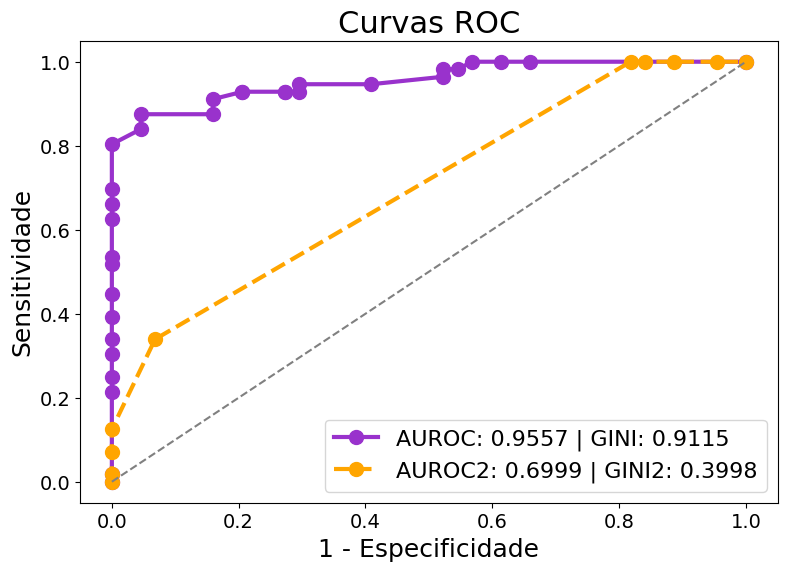

In [50]:
#%% Plotando as curvas ROCs
plt.figure(figsize=(9,6))

plt.plot(fpr, tpr, marker='o', color='darkorchid', markersize=10, linewidth=3,
         label=f'AUROC: {roc_auc:.4f} | GINI: {gini:.4f}')
plt.plot(fpr2, tpr2, marker='o', color='orange', markersize=10, linewidth=3,
         linestyle = 'dashed',
         label=f'AUROC2: {roc_auc2:.4f} | GINI2: {gini2:.4f}')
plt.plot(fpr, fpr, color='gray', linestyle='dashed')
plt.title('Curvas ROC', fontsize=22)
plt.xlabel('1 - Especificidade', fontsize=18)
plt.ylabel('Sensitividade', fontsize=18)
plt.xticks(np.arange(0, 1.1, 0.2), fontsize=14)
plt.yticks(np.arange(0, 1.1, 0.2), fontsize=14)
plt.legend(fontsize = 16)
plt.show()